In [6]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, FashionMNIST

In [7]:
train_set = FashionMNIST(:train)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

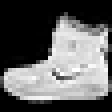

In [8]:
convert2image(FashionMNIST, train_set.features)[:,:,1]

In [9]:
use_cuda = true
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sdnNjb2RlLXJlbW90ZQ==.jl:4


In [10]:
epochs = 150;
batch_size = 64;

In [11]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X)[1], size(X)[2], 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, 1, i] = Float32.(X[:, :, idxs[i]])
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end


make_minibatch (generic function with 1 method)

In [12]:
mb_idxs = partition(1:size(train_set.features)[3], batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

938-element Vector{Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 0])
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … 

In [13]:
test_set = FashionMNIST(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[3]) |> device

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 1 0 … 0 0])

In [14]:
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device

Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  var"#13#14"(),
  Dense(288 => 128),                    # 36_992 parameters
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 52_330 parameters, 1.961 KiB.

In [15]:
model(train_set[1][1])

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.132105   0.128793   0.11353    …  0.120433   0.114458   0.109565
 0.116719   0.10153    0.0981063     0.101412   0.120432   0.112312
 0.0997213  0.0874415  0.0898499     0.0899084  0.101789   0.103025
 0.0956289  0.112312   0.0975442     0.102637   0.0951563  0.0997172
 0.0953677  0.0905564  0.103445      0.0951945  0.0955397  0.0973922
 0.0946034  0.105409   0.101924   …  0.102384   0.0967843  0.0958434
 0.0810437  0.0688525  0.0890232     0.076106   0.080224   0.085484
 0.0951543  0.101119   0.101852      0.102188   0.102854   0.0998857
 0.102577   0.107872   0.101005      0.110219   0.0991334  0.0995049
 0.0870795  0.0961154  0.103722      0.0995175  0.0936292  0.0972707

In [16]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [17]:
loss(model, test_set[1],test_set[2])
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))
@time accuracy(model,test_set[1],test_set[2])

  7.007030 seconds (9.03 M allocations: 462.518 MiB, 0.99% gc time, 83.44% compilation time)


0.0998

In [18]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [19]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model, train_set, opt_state)
    acc = accuracy(model,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        ps = cpu(Flux.state(model))
        BSON.@save "fashionMNIST_conv.bson" ps
        jldsave("fashionMNIST_conv.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90ZQ==.jl:1
┌ Info: [1]: Test accuracy: 0.8540
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90ZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90ZQ==.jl:10
┌ Info: [2]: Test accuracy: 0.8665
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90ZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90ZQ==.jl:10
┌ Info: [3]: Test accuracy: 0.8734
└ @ Main /home/cuongvosgh/Deep_learning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sdnNjb2RlLXJlbW90

In [ ]:
isfile("fashionMNIST_conv.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.bson?raw=true")

model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device

BSON.@load "fashionMNIST_conv.bson" ps

Flux.loadmodel!(model, device(ps))

In [ ]:
accuracy(model,test_set[1],test_set[2])

In [ ]:
isfile("fashionMNIST_conv.jld2") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.jld2?raw=true")

model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device


ps = JLD2.load("fashionMNIST_conv.jld2", "ps")

Flux.loadmodel!(model, device(ps))

In [ ]:
accuracy(model,test_set[1],test_set[2])

In [ ]:
con = Chain(model.layers[1:1]...)